# Set for jupyter notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Env

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import os
import random
from PIL import Image

In [3]:
from modules.dataset import get_loader
from modules.utils import imsshow, imgshow
from modules.network import UNet
from modules.loss import MyBinaryCrossEntropy
from modules.solver import Lab2Solver

In [4]:
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data process

In [5]:
BG = [0]
RV = [85]
MYO = [170]
LV = [255]

train_loader = get_loader(image_root_path='./ACDC-2D-All/train/',palette=[RV,MYO,LV], batch_size=32, mode='train')
val_loader = get_loader(image_root_path='./ACDC-2D-All/val/', palette=[RV,MYO,LV], batch_size=32, mode='val')
test_loader = get_loader(image_root_path='./ACDC-2D-All/test/',palette=[RV,MYO,LV], batch_size=32, mode='test')

image count in train path :1394
image count in val path :200
image count in test path :204


torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


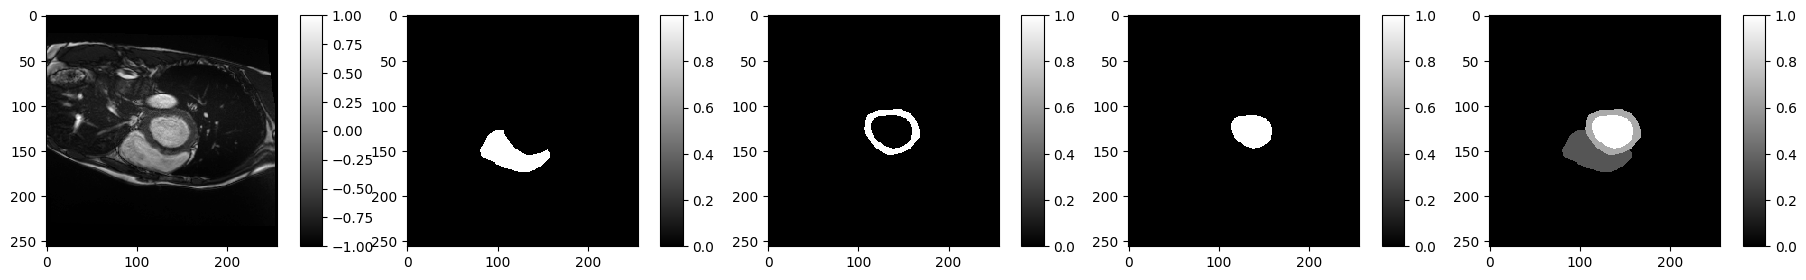

Number of 0.0 in the array: 61277
Number of 0.3333333432674408 in the array: 1833
Number of 0.6666666865348816 in the array: 1097
Number of 1.0 in the array: 1329


In [6]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 10
all_gt = (seg_gt[idx,0, :, :] * 85 + seg_gt[idx,1, :, :] * 170 + seg_gt[idx,2, :, :] * 255)/255
imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :],seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :], all_gt], is_colorbar=True, is_ticks=True)

# for testing
# imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)

target = all_gt
unique, count = np.unique(target, return_counts=True)

# Print the results
for u, c in zip(unique, count):
    print("Number of {} in the array: {}".format(u, c))

torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


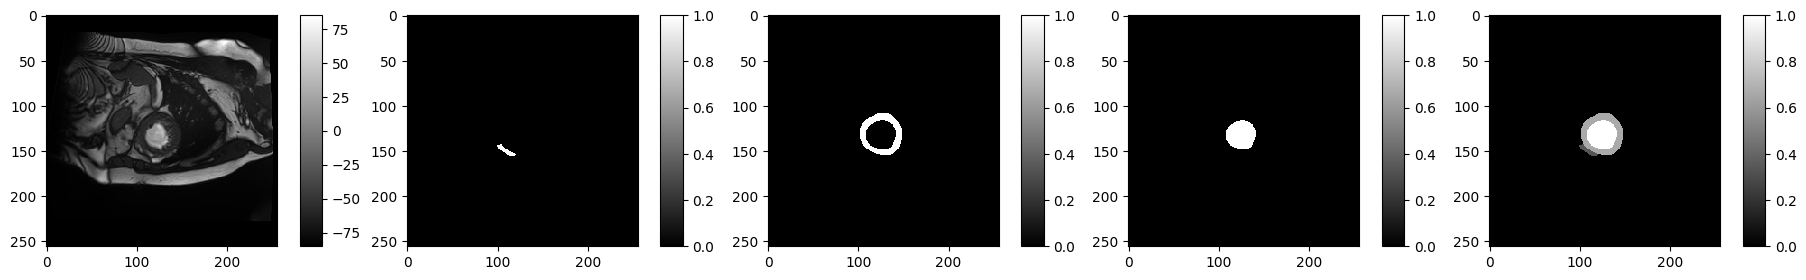

Number of 0.0 in the array: 63730
Number of 0.3333333432674408 in the array: 96
Number of 0.6666666865348816 in the array: 865
Number of 1.0 in the array: 845


In [7]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(val_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 5
all_gt = (seg_gt[idx,0, :, :] * 85 + seg_gt[idx,1, :, :] * 170 + seg_gt[idx,2, :, :] * 255)/255
imsshow([image[idx, 0, :, :]* 85, seg_gt[idx, 0, :, :],seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :], all_gt], is_colorbar=True, is_ticks=True)

# for testing
# imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)

target = all_gt
unique, count = np.unique(target, return_counts=True)

# Print the results
for u, c in zip(unique, count):
    print("Number of {} in the array: {}".format(u, c))

# Network and Solver

In [27]:
checkpoint = "./checkpoint/04-06_18-32-42-v1.1-20+20epoch.pth"
net = UNet(n_channels=1, n_classes=3, C_base=32)
net.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [30]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.006)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

solver = Lab2Solver(
    model = net,
    optimizer = optimizer,
    criterion = MyBinaryCrossEntropy(),
    lr_scheduler=lr_scheduler,
    device="cuda:2"
)

# Train

  0%|          | 0/1394 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

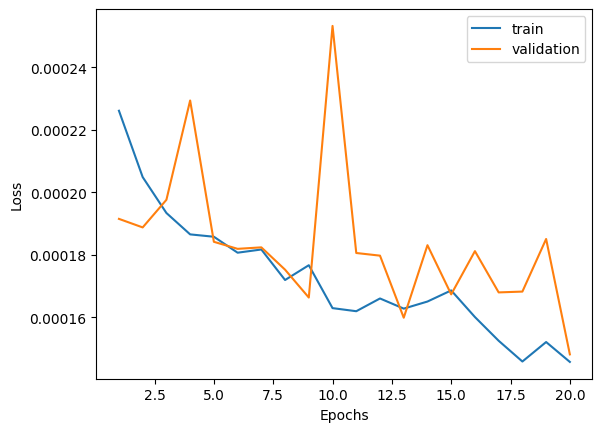

In [31]:
solver.train(
    epochs=20, 
    data_loader=train_loader,
    val_loader=val_loader
)

In [23]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
print(seg_gt.dtype)

torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])
torch.float32


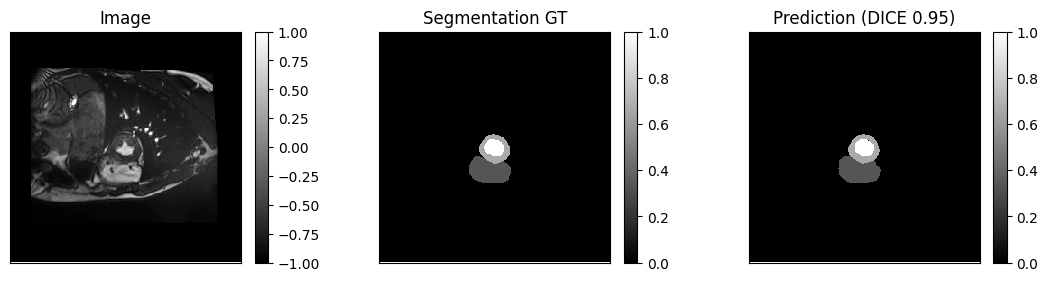

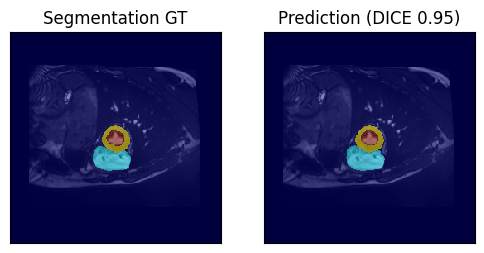

In [39]:
solver.visualize(test_loader, 11)

In [33]:
solver.validate(
    data_loader=test_loader
)

[Validation]:   0%|          | 0/204 [00:00<?, ?img/s]

============================== Measurements ==============================
[avg_Sensitivity] 0.9155839219853761
[avg_Specifity] 0.9993124463961521
[avg_Precision] 0.9195791467903993
[avg_F1Score] 0.9174908155081049
[avg_JaccardSimilarity] 0.8476944344624312
[avg_DiceCoefficient] 0.9174913154687717


# Save checkpoint

In [34]:
import time
timestamp = time.strftime("%m-%d_%H-%M-%S", time.localtime())

In [35]:
name = "v1.1-20+20+20epoch"
torch.save(net.state_dict(), f'./checkpoint/{timestamp}-{name}.pth')